In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
# load data
items=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
cats=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")
train=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test=pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

In [3]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


<AxesSubplot:xlabel='date'>

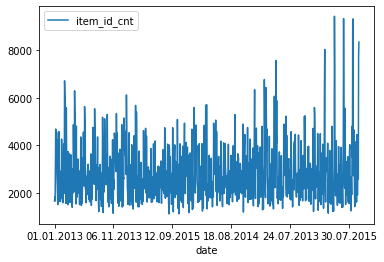

In [4]:
temp2=train.groupby('date')['item_id'].count()
df=pd.DataFrame(temp2)
df.columns.map({'item_id':'item_id_cnt'})
df.rename(columns={'item_id':'item_id_cnt'},inplace=True)
df.plot()

In [5]:
temp=train[train['date']=='02.01.2013']

In [6]:
temp.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
6,02.01.2013,0,25,2565,549.0,1.0
28,02.01.2013,0,25,2546,299.0,1.0


In [7]:
temp2=train[train['item_id']==5037][train['shop_id']==5][['date','item_cnt_day']]
#Convert datetime type
import datetime
def str_to_datetime(s):
    split=s.split('.')
    d,m,y=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=y,month=m,day=d)
temp2['date']=temp2['date'].apply(str_to_datetime).sort_values()
temp2#Now proper format

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,item_cnt_day
1953995,2014-09-21,1.0
2150561,2014-11-29,1.0
2288630,2014-12-28,1.0
2288631,2014-12-20,1.0
2335446,2015-01-02,1.0
2335447,2015-01-07,1.0
2618926,2015-05-29,1.0
2704068,2015-06-28,1.0
2719247,2015-07-05,1.0
2810661,2015-08-14,1.0


The aim is to predict the monthly sales of items in specific shops, given historical data. The sale counts are clipped between 0 and 20.

In [8]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


<AxesSubplot:xlabel='item_price'>

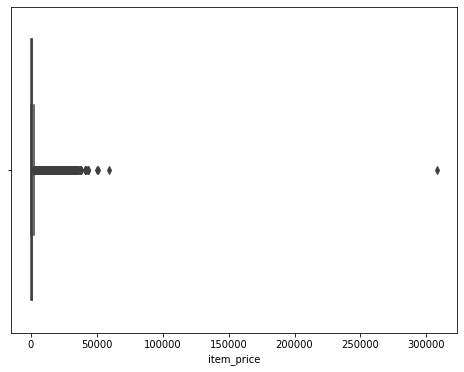

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x=train['item_price'])

<AxesSubplot:xlabel='item_cnt_day'>

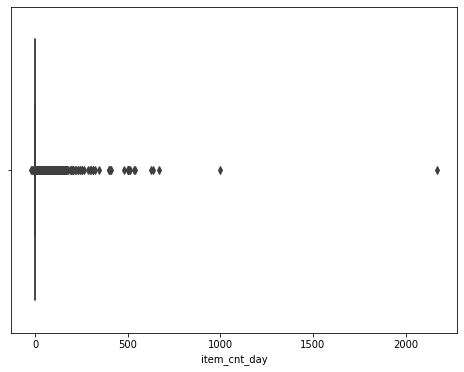

In [10]:
f,ax=plt.subplots(figsize=(8,6))
sns.boxplot(x=train['item_cnt_day'])

In [11]:
train = train[(train.item_price < 250000 )& (train.item_cnt_day < 1000)]

In [12]:
train = train[train.item_price > 0].reset_index(drop = True)
train.loc[train.item_cnt_day < 1, "item_cnt_day"] = 0

In [13]:
shops['city']=shops.shop_name.str.split(" ").map(lambda x:x[0])
shops['category']=shops.shop_name.str.split(" ").map(lambda x:x[1])
shops.head(3)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,"Орджоникидзе,"
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ


In [14]:
category=[]
for cat in shops['category'].unique():
    if len(shops[shops['category']==cat])>=5:
        category.append(cat)
shops.category=shops.category.apply(lambda x: x if (x in category) else 'others')
shops.head(3)

,shop_name,shop_id,city,category
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,others
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,ТЦ
2,"Адыгея ТЦ ""Мега""",2,Адыгея,ТЦ


In [15]:
from sklearn.preprocessing import LabelEncoder
shops['category']=LabelEncoder().fit_transform(shops.category)
shops['city']=LabelEncoder().fit_transform(shops.city)

In [16]:
shops=shops[['shop_id','city','category']]

In [17]:
cats['type']=cats.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)

In [18]:
categ=[]
for cat in cats.type.unique():
    if len(cats[cats.type==cat])>=5:
        categ.append(cat)
cats.type=cats.type.apply(lambda x: x if (x in categ) else 'others')
cats.head(3)

,item_category_name,item_category_id,type
0,PC - Гарнитуры/Наушники,0,others
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары


In [19]:
cats['type_code']=LabelEncoder().fit_transform(cats.type)

In [20]:
cats['split']=cats.item_category_name.apply(lambda x: x.split('-'))
cats['sub_type']=cats.split.apply(lambda x: x[1].strip() if len(x)>1 else x[0].strip())

In [21]:
cats['sub_type_code']=LabelEncoder().fit_transform(cats.sub_type)
cats=cats[['item_category_id','type_code','sub_type_code']]

In [22]:
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [23]:
items.drop(['item_name'],inplace=True,axis=1)

In [24]:
#import re
#def name_correction(x):
#    x = x.lower() # all letters lower case
#    x = x.partition('[')[0] # partition by square brackets
#    x = x.partition('(')[0] # partition by curly brackets
#    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x) # remove special characters
#    x = x.replace('  ', ' ') # replace double spaces with single spaces
#    x = x.strip() # remove leading and trailing white space
#    return x

In [25]:
# split item names by first bracket
#items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
#items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

# replace special characters and turn to lower case
#items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
#items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
#items = items.fillna('0')

In [26]:
#items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.head(3)

,item_id,item_category_id
0,0,40
1,1,76
2,2,40


In [27]:
#items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
#items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
#items.loc[ items.type == "", "type"] = "mac"
#items.type = items.type.apply( lambda x: x.replace(" ", "") )
#items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
#items.loc[ items.type == 'рs3' , "type"] = "ps3"


In [28]:
#group_sum = items.groupby(["type"]).agg({"item_id": "count"})
#group_sum = group_sum.reset_index()
#drop_cols = []
#for cat in group_sum.type.unique():
#    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
#        drop_cols.append(cat)
#items.name2 = items.name2.apply( lambda x: "other" if (x in drop_cols) else x )
#items = items.drop(["type"], axis = 1)


In [29]:
#items.name2 = LabelEncoder().fit_transform(items.name2)
#items.name3 = LabelEncoder().fit_transform(items.name3)

#items.drop(["item_name", "name1"],axis = 1, inplace= True)
#items.head()

In [30]:
train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,0.0


In [31]:
train.date_block_num.nunique()

34

In [32]:
from itertools import product
matrix=[]
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales=train[train.date_block_num==i]
    matrix.append(np.array(list(product( [i], sales.shop_id.unique(), sales.item_id.unique()))))
matrix=pd.DataFrame(np.vstack(matrix),columns=cols)
matrix.head(3)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554


In [33]:
matrix['date_block_num']=matrix['date_block_num'].astype(int)
matrix['shop_id']=matrix['shop_id'].astype(np.int8)
matrix['item_id']=matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)


In [34]:
train['revenue']=train['item_cnt_day']*train['item_price']

In [35]:
group=train.groupby(cols).agg({'item_cnt_day':['sum']})
group.columns=['item_cnt_month']
group.reset_index(inplace=True)
group

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [36]:
matrix=pd.merge(matrix,group,on=cols,how='left')
matrix['item_cnt_month']=matrix['item_cnt_month'].fillna(0).astype(np.float16)

In [37]:
test['date_block_num']=34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test['shop_id']=test['shop_id'].astype(np.int8)
test['item_id']=test['item_id'].astype(np.int16)

In [38]:
test.drop('ID',inplace=True,axis=1)

In [39]:
test.shape

(214200, 3)

In [40]:
matrix=pd.concat([matrix,test],ignore_index=True,sort=False,keys=cols)
matrix.fillna(0,inplace=True)
matrix.tail(5)

,date_block_num,shop_id,item_id,item_cnt_month
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


In [41]:
matrix[matrix['date_block_num']==34].shape

(214200, 4)

In [42]:
shops.head(2)

,shop_id,city,category
0,0,0,0
1,1,0,4


In [43]:
matrix=pd.merge(matrix,shops,on=['shop_id'],how='left')
matrix.head(4)

,date_block_num,shop_id,item_id,item_cnt_month,city,category
0,0,0,19,0.0,0,0
1,0,0,27,0.0,0,0
2,0,0,28,0.0,0,0
3,0,0,29,0.0,0,0


In [44]:
items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [45]:
matrix=pd.merge(matrix,items,on='item_id',how='left')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id
0,0,0,19,0.0,0,0,40
1,0,0,27,0.0,0,0,19
2,0,0,28,0.0,0,0,30


In [46]:
cats.head(2)

,item_category_id,type_code,sub_type_code
0,0,0,29
1,1,1,9


In [47]:
matrix=pd.merge(matrix,cats,on='item_category_id',how='left')
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code
0,0,0,19,0.0,0,0,40,5,4
1,0,0,27,0.0,0,0,19,3,10
2,0,0,28,0.0,0,0,30,3,55


In [48]:
matrix.tail(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code
11128001,34,45,15757,0.0,21,4,55,7,2
11128002,34,45,19648,0.0,21,4,40,5,4
11128003,34,45,969,0.0,21,4,37,5,1


In [49]:
matrix["city"] = matrix["city"].astype(np.int8)
matrix["category"] = matrix["category"].astype(np.int8)
matrix["item_category_id"] = matrix["item_category_id"].astype(np.int8)
matrix["sub_type_code"] = matrix["sub_type_code"].astype(np.int8)
#matrix["name2"] = matrix["name2"].astype(np.int8)
#matrix["name3"] = matrix["name3"].astype(np.int16)
matrix["type_code"] = matrix["type_code"].astype(np.int8)

In [50]:
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code
0,0,0,19,0.0,0,0,40,5,4
1,0,0,27,0.0,0,0,19,3,10
2,0,0,28,0.0,0,0,30,3,55


In [51]:
matrix[matrix['date_block_num']==34].shape

(214200, 9)

In [52]:
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code
0,0,0,19,0.0,0,0,40,5,4
1,0,0,27,0.0,0,0,19,3,10
2,0,0,28,0.0,0,0,30,3,55


In [53]:
def lag_feature(df,lags,cols ):
    for col in cols:
        print('Adding lag feature in ',col)
        tmp=df[['date_block_num','shop_id','item_id',col]]
        for i in lags:
            shifted=tmp.copy()
            shifted.columns=['date_block_num','shop_id','item_id',col+'_shifted_'+str(i)]
            shifted.date_block_num=shifted.date_block_num+i
            df=pd.merge(df,shifted,on=['date_block_num','shop_id','item_id'],how='left')
    return df

In [54]:
matrix=lag_feature(matrix,[1,2],["item_cnt_month"])

Adding lag feature in  item_cnt_month


In [55]:
group=matrix.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_cat_avg']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_category_id'],how='left')
matrix['date_item_cat_avg']=matrix['date_item_cat_avg'].astype(np.float16)

In [56]:
matrix=lag_feature(matrix,[1,2],['date_item_cat_avg'])
matrix.drop(['date_item_cat_avg'],axis=1,inplace=True)

Adding lag feature in  date_item_cat_avg


In [57]:
group=matrix.groupby(['date_block_num','category']).agg({'item_cnt_month':['mean']})
group.columns=['date_cat_avg']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','category'],how='left')
matrix['date_cat_avg']=matrix['date_cat_avg'].astype(np.float16)

In [58]:
matrix=lag_feature(matrix,[1,2],['date_cat_avg'])
matrix.drop(['date_cat_avg'],axis=1,inplace=True)

Adding lag feature in  date_cat_avg


In [59]:
group=matrix.groupby(['date_block_num']).agg({'item_cnt_month':['mean']})
group.columns=['date_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on='date_block_num',how='left')
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)

In [60]:
matrix=lag_feature(matrix,[1,2],["date_avg_item_cnt"])
matrix.drop(['date_avg_item_cnt'],inplace=True,axis=1)

Adding lag feature in  date_avg_item_cnt


In [61]:
group=matrix.groupby(['date_block_num','item_id']).agg({'item_cnt_month':['mean']})
group.columns=['date_item_avg_item_cnt']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix.date_item_avg_item_cnt=matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code,item_cnt_month_shifted_1,item_cnt_month_shifted_2,date_item_cat_avg_shifted_1,date_item_cat_avg_shifted_2,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt
0,0,0,19,0.0,0,0,40,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022217
1,0,0,27,0.0,0,0,19,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.155518
2,0,0,28,0.0,0,0,30,3,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177734


In [62]:
matrix=lag_feature(matrix,[1,2],['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'],inplace=True,axis=1)

Adding lag feature in  date_item_avg_item_cnt


In [63]:
#group=matrix.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_month':['mean']})
#group.columns=['date_shop_item_avg_item_cnt']
#group.reset_index(inplace=True)
#matrix=pd.merge(matrix,group,on=['date_block_num','shop_id','shop_id'],how='left')
#matrix.date_shop_item_avg_item_cnt=matrix['date_shop_item_avg_item_cnt'].astype(np.float16)
#matrix.head(3)

In [64]:
#matrix=lag_feature(matrix,[1,2],['date_shop_item_avg_item_cnt'])
#matrix.drop(['date_shop_item_avg_item_cnt'],inplace=True,axis=1)

In [65]:
#group=matrix.groupby(['date_block_num','city','item_id']).agg({'item_cnt_month':['mean']})
#group.columns=['date_city_item_avg_item_cnt']
#group.reset_index(inplace=True)
#matrix=pd.merge(matrix,group,on=['date_block_num','city','shop_id'],how='left')
#matrix.date_city_item_avg_item_cnt=matrix['date_city_item_avg_item_cnt'].astype(np.float16)
#matrix.head(3)

In [66]:
#matrix=lag_feature(matrix,[1,2],['date_city_item_avg_item_cnt'])
#matrix.drop(['date_city_item_avg_item_cnt'],inplace=True,axis=1)

In [67]:
group=train.groupby(['item_id']).agg({'item_price':['mean']})
group.columns=['item_id_price_avg']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['item_id'],how='left')
matrix['item_id_price_avg']=matrix['item_id_price_avg'].astype(np.float16)

In [68]:
group=train.groupby(['date_block_num','item_id']).agg({'item_price':['mean']})
group.columns=['date_item_id_price_avg']
group.reset_index(inplace=True)
matrix=pd.merge(matrix,group,on=['date_block_num','item_id'],how='left')
matrix['date_item_id_price_avg']=matrix['date_item_id_price_avg'].astype(np.float16)

In [69]:
matrix=lag_feature(matrix,[1,2],['date_item_id_price_avg'])

Adding lag feature in  date_item_id_price_avg


In [70]:
matrix.head(2)

,date_block_num,shop_id,item_id,item_cnt_month,city,category,item_category_id,type_code,sub_type_code,item_cnt_month_shifted_1,...,date_cat_avg_shifted_1,date_cat_avg_shifted_2,date_avg_item_cnt_shifted_1,date_avg_item_cnt_shifted_2,date_item_avg_item_cnt_shifted_1,date_item_avg_item_cnt_shifted_2,item_id_price_avg,date_item_id_price_avg,date_item_id_price_avg_shifted_1,date_item_id_price_avg_shifted_2
0,0,0,19,0.0,0,0,40,5,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,28.0,28.0,NaN,NaN
1,0,0,27,0.0,0,0,19,3,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1461.0,2324.0,NaN,NaN


In [71]:
for i in [1,2]:
    matrix['delta_price_shifted_'+str(i)]=(matrix['date_item_id_price_avg_shifted_'+str(i)]-matrix['item_id_price_avg'])/matrix['item_id_price_avg']
features_to_drop = ["item_id_price_avg", "date_item_id_price_avg"]
matrix.drop(features_to_drop, axis = 1, inplace = True)

In [72]:
matrix = matrix[matrix["date_block_num"] > 2]

In [73]:
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [74]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month']
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month']
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [75]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [76]:
model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=42)
model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:1.17804	validation_1-rmse:1.12187
[1]	validation_0-rmse:1.13428	validation_1-rmse:1.08729
[2]	validation_0-rmse:1.09558	validation_1-rmse:1.05914
[3]	validation_0-rmse:1.06352	validation_1-rmse:1.03719
[4]	validation_0-rmse:1.03574	validation_1-rmse:1.01769
[5]	validation_0-rmse:1.01315	validation_1-rmse:1.00310
[6]	validation_0-rmse:0.99458	validation_1-rmse:0.99241
[7]	validation_0-rmse:0.97717	validation_1-rmse:0.98208
[8]	validation_0-rmse:0.96233	validation_1-rmse:0.97374
[9]	validation_0-rmse:0.95031	validation_1-rmse:0.96571
[10]	validation_0-rmse:0.93975	validation_1-rmse:0.95968
[11]	validation_0-rmse:0.93067	validation_1-rmse:0.95514
[12]	validation_0-rmse:0.92235	validation_1-rmse:0.95137
[13]	validation_0-rmse:0.91544	validation_1-rmse:0.94812
[14]	validation_0-rmse:0.90915	validation_1-rmse:0.94369
[15]	validation_0-rmse:0.90378	validation_1-rmse:0.94219
[16]	validation_0-rmse:0.89906	validation_1-rmse:0.94080
[17]	validation_0-rmse:0.89441	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=0.5,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, ...)

In [77]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

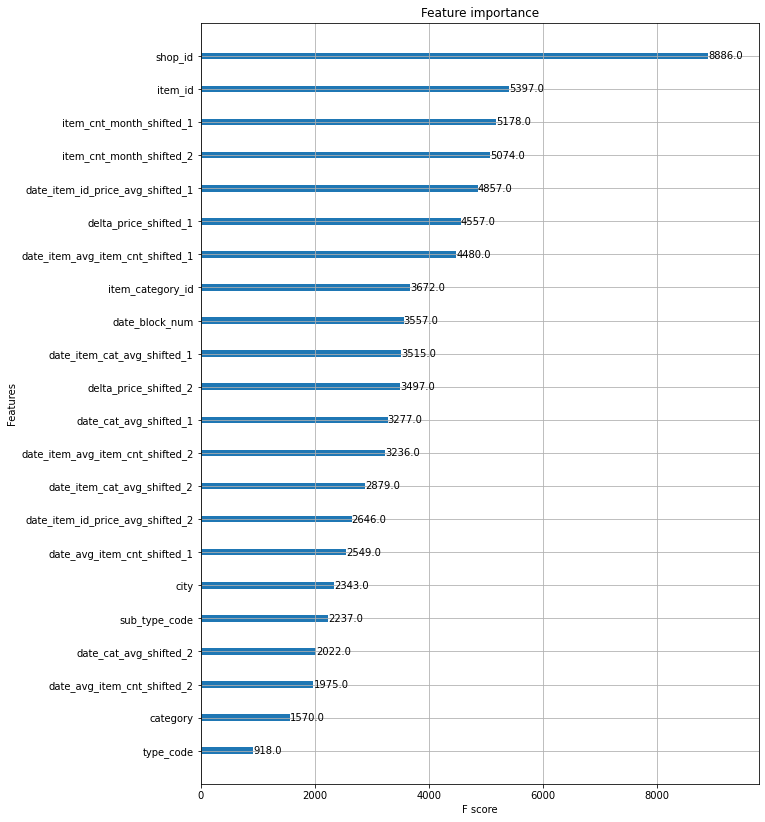

In [78]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))